In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

# métricas de avaliação
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.utils.multiclass import unique_labels

# Reamostragem dos dados
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# outras
import time
import pickle
import warnings
from scipy import interp
from pprint import pprint
from scipy.stats import norm
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

%matplotlib inline
mpl.style.use('ggplot')
plt.style.use('fivethirtyeight')
sns.set(context='notebook', palette='dark', color_codes=True)

#Ignorar warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'seaborn'

In [2]:
data = pd.read_csv("data/dataset_norm_qtde.csv", index_col=0)
data.head(5)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1.0,0.042473,0.0,0.686294,0.4610,0.090909,0.791392,0.0,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,0.8
1,0.0,0.026971,0.0,0.426396,0.1660,0.090909,0.597377,1.0,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,0.8
2,0.0,0.038679,0.0,0.444670,0.3590,0.000000,0.736123,1.0,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,0.8
3,1.0,0.036978,0.0,0.270051,0.0596,0.000000,0.573701,1.0,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,0.6
4,1.0,0.036389,0.0,0.627411,0.4430,0.181818,0.737103,1.0,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,0.8


# Dividindo o dataset em treino, validação e teste

In [3]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [4]:
# Visualizando as proporções do atributo alvo
df_train["popularity"].value_counts(normalize=True)

0.0    0.952146
1.0    0.047854
Name: popularity, dtype: float64

In [5]:
df_test["popularity"].value_counts(normalize=True)

0.0    0.950638
1.0    0.049362
Name: popularity, dtype: float64

## Validação cruzada

In [6]:
X, y = df_train.drop('popularity', axis=1), df_train["popularity"]

In [7]:
KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
# Separando dados em treino e validação
for train_index, val_index in KFold.split(X, y):

    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [56]:
print(f"X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"X_val = {X_val.shape}, y_val = {y_val.shape}\n")
print(f"Proporção do df_train para classe=1: {round(len(df_train[df_train.popularity==1]) / df_train.shape[0], 4)}\n")
print(f"Proporção de X_train para classe=1:  {round(len(y_train[y_train==1]) / X_train.shape[0], 4)}")
print(f"Proporção de X_val para classe=1:    {round(len(y_val[y_val==1]) / X_val.shape[0], 4)}\n")
print(f"Quantidade de musicas populares: {len(data[data.popularity == 1.0])}")
print(f"Quantidade de musicas não populares: {len(data[data.popularity == 0.0])}")

X_train = (72672, 14), y_train = (72672,)
X_val = (18167, 14), y_val = (18167,)

Proporção do df_train para classe=1: 0.0479

Proporção de X_train para classe=1:  0.0479
Proporção de X_val para classe=1:    0.0478

Quantidade de musicas populares: 5468
Quantidade de musicas não populares: 108081


# Dia 4 - Definindo o baseline
> Uma linha de base (baseline) é o resultado de um modelo/solução muito básico. Você geralmente cria uma linha de base e depois tenta fazer soluções mais complexas para obter um resultado melhor. Se você conseguir uma pontuação melhor do que a linha de base, é bom.

In [29]:
reg = LogisticRegression()

reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)

y_pred_val = reg.predict(X_val)

In [34]:
reg.coef_

array([[-1.21446716,  0.5439353 ,  0.94504929, -1.43527323, -0.0254846 ,
         4.27641958, -0.09312669, -1.95441783, -1.21806524, -2.176823  ,
        -1.37461457, -0.25482184, -0.94426236,  0.41652551]])

In [40]:
df_coef = data.drop(columns='popularity')

dictio = {
    "Features": df_coef.columns,
    "Coef": reg.coef_.tolist()[0]
}
df = pd.DataFrame(dictio)
df

,Features,Coef
0,duration_ms,-1.214467
1,explicit,0.543935
2,danceability,0.945049
3,energy,-1.435273
4,key,-0.025485
5,loudness,4.276420
6,mode,-0.093127
7,speechiness,-1.954418
8,acousticness,-1.218065
9,instrumentalness,-2.176823


# Dia 5 - Validação do baseline

In [47]:
def plot_confusion_matrix(y_test, y_pred, percent=False):
    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    #print(cm_norm)
    
    classes = unique_labels(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4))
    if percent:
      #sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Reds')
      sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds')
    else:
      sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax)
    ax.set_xlabel('Previsões')
    ax.set_ylabel('Valores reais')
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes, rotation=0)

    title = 'Matriz de confusão'
    ax.set_title(title, fontsize=10)

    plt.tight_layout()
    plt.show()

In [42]:
print('\t Regressão Logística (baseline)\n')
print('---' * 20)
print('Nos dados de TREINO:')
print('---' * 20)
print(f"accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"precision: {precision_score(y_train, y_pred_train)}")
print(f"recall:    {recall_score(y_train, y_pred_train)}")
print(f"f1:        {f1_score(y_train, y_pred_train)}")
print()
print('---' * 20)
print('---' * 20)
print()
print('Nos dados de VALIDAÇÃO:')
print('---' * 20)
print('Modelo:    Regressão Logística (baseline)\n')
print(f"accuracy:  {accuracy_score(y_val, y_pred_val)}")
print(f"precision: {precision_score(y_val, y_pred_val)}")
print(f"recall:    {recall_score(y_val, y_pred_val)}")
print(f"f1:        {f1_score(y_val, y_pred_val)}")
print('---' * 20)

	 Regressão Logística (baseline)

------------------------------------------------------------
Nos dados de TREINO:
------------------------------------------------------------
accuracy:  0.9521411272567151
precision: 0.0
recall:    0.0
f1:        0.0

------------------------------------------------------------
------------------------------------------------------------

Nos dados de VALIDAÇÃO:
------------------------------------------------------------
Modelo:    Regressão Logística (baseline)

accuracy:  0.9521660153024715
precision: 0.0
recall:    0.0
f1:        0.0
------------------------------------------------------------


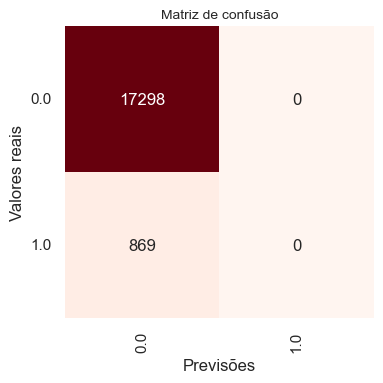

In [50]:
plot_confusion_matrix(y_val, y_pred_val)